In [16]:
!pip install --upgrade hifi-gan-bwe

In [17]:
!pip install scipy

In [18]:
import audioread
import numpy as np
import torch
import torchaudio
from IPython.display import Audio
from hifi_gan_bwe import BandwidthExtender
import os
from scipy.signal import spectrogram

In [19]:
model = BandwidthExtender.from_pretrained("hifi-gan-bwe-10-42890e3-vctk-48kHz")

In [20]:
originalFilePath = "FullBandFiles/p232_001.wav"

In [21]:
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from scipy.signal import decimate, upfirdn, firwin

fs, original_data = wav.read(originalFilePath)

def plot_signal(data, fs):
    n = len(data)
    x_axis = np.linspace(0, n/fs, n)
    plt.plot(x_axis, original_data)
    plt.show()



In [22]:
new_fs = 16000
q = int(fs/new_fs)

def downsample_data(data):
    downsampled_data = decimate(data, q, ftype='fir', zero_phase=True) #Zero_phase=True hindrer faseforstyrrelse
    wav.write('downsampled_audio.wav', new_fs, downsampled_data.astype(np.int16))
    path = 'downsampled_audio.wav'

    return downsampled_data, path

#downsampled_data, filepath = downsample_data(original_data)

In [23]:

# Function to upsample a signal
def upsample_signal(signal: np.ndarray, input_sample_rate: int, target_sample_rate: int) -> np.ndarray:
    # Convert the signal to a PyTorch tensor
    x = torch.from_numpy(signal).float()
    
    # Ensure the signal is in the correct shape (batch size, channels, samples)
    if len(x.shape) == 1:
        x = x.unsqueeze(0).unsqueeze(0)
    elif len(x.shape) == 2:
        x = x.unsqueeze(0)

    # Perform the resampling
    x_upsampled = torchaudio.functional.resample(
        x,
        orig_freq=input_sample_rate,
        new_freq=target_sample_rate,
        resampling_method="kaiser_window",
        lowpass_filter_width=16,
        rolloff=0.945,
        beta=14.769656459379492,
    )
    
    # If the original signal was 1D, squeeze the result back to 1D
    if len(signal.shape) == 1:
        x_upsampled = x_upsampled.squeeze(0).squeeze(0)
    elif len(signal.shape) == 2:
        x_upsampled = x_upsampled.squeeze(0)

    # Convert the upsampled tensor back to a NumPy array
    upsampled_signal = x_upsampled.numpy()
    
    return upsampled_signal



In [24]:
def preprocess_data(filepath):
    with audioread.audio_open(filepath) as input_:
        sample_rate = input_.samplerate
        x = (
            np.hstack([np.frombuffer(b, dtype=np.int16) for b in input_])
            .reshape([-1, input_.channels])
            .astype(np.float32)
            / 32767.0
        )
    return x

#preprocessed_data = preprocess_data(filepath)  

In [25]:
def run_model(preprocessed_data):
    with torch.no_grad():
        y = np.stack([model(torch.from_numpy(preprocessed_data), new_fs) for preprocessed_data in preprocessed_data.T]).T
    return y


#y = run_model(preprocessed_data)

In [26]:
def upsample_signal(signal):
    upsample_factor = 3


    # Create an upsampled array with zeros
    upsampled_signal = np.zeros(len(signal) * upsample_factor)
    upsampled_signal[::upsample_factor] = signal  # Insert the original data every 3 samples
    
    # Step 2: Low-pass filter to interpolate between the zero-inserted samples
    # Design a low-pass FIR filter with a cutoff frequency at 8 kHz
    cutoff_freq = 8000  # cutoff frequency in Hz
    numtaps = 101  # Number of filter taps (increase for sharper cutoff)
    lpf = firwin(numtaps, cutoff_freq, fs=new_fs * upsample_factor, window='hamming')
    
    # Apply the filter
    interpolated_signal = upfirdn(lpf, upsampled_signal, up=1, down=1)

    return interpolated_signal

In [33]:
folderpath = 'FullBandFiles'
filename = os.listdir(folderpath)[169]
filepath = os.path.join(folderpath, filename)


fs, original_data = wav.read(originalFilePath)


#Downsample data and save as file
downsampled_data, filepath = downsample_data(original_data)

#Upsample data
upsampled_data = upsample_signal(downsampled_data)

#Run model
prepped_data = preprocess_data(filepath)
bwe_data = run_model(prepped_data)
bwe_data = bwe_data.reshape(-1)

bckgrnd_sig = np.ones(3*len(downsampled_data))

print(np.max(original_data/32767))
print(np.max(bwe_data))

0.45985290078432567
0.46163538


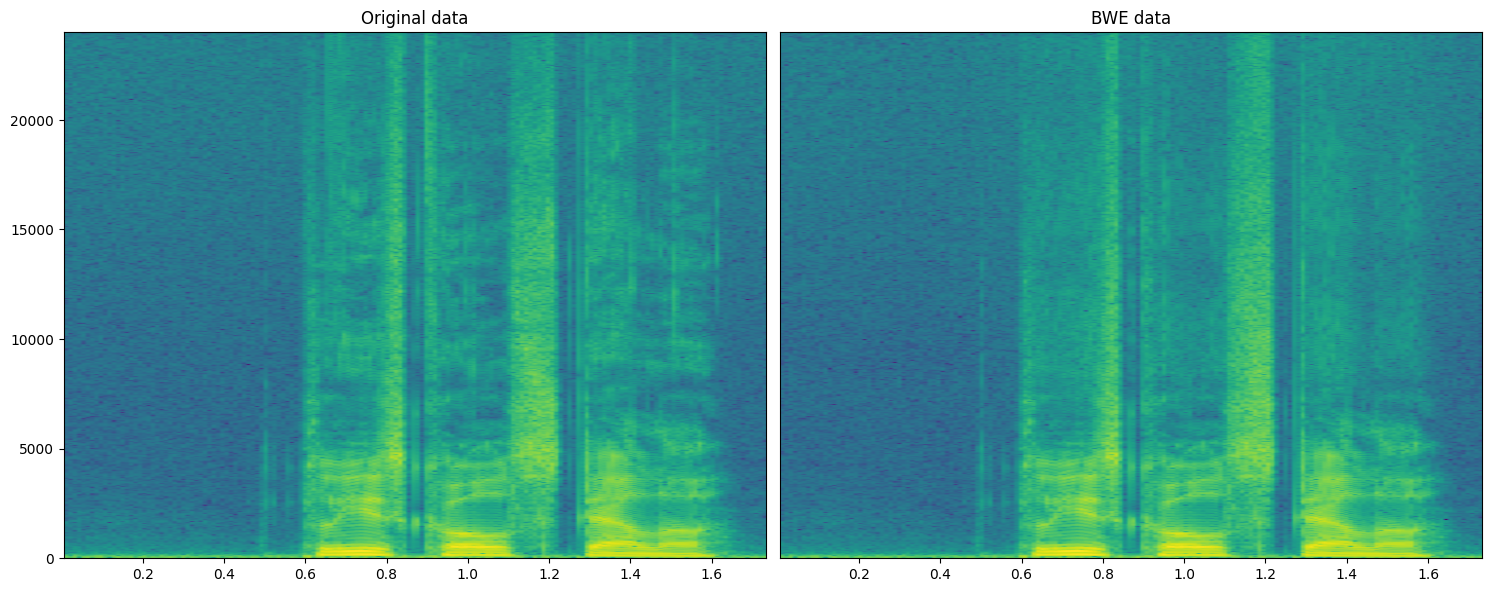

In [34]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 6))

n = 1024

original_data = original_data/32767

ax1.specgram(original_data, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
ax1.set_title('Original data')
ax3.specgram(bwe_data, NFFT=n, Fs=fs, noverlap=int(n/2), scale = "dB")
ax3.set_title('BWE data')
ax3.set_yticks([])
fig.tight_layout(pad=1.0)

fig.savefig('Results/spectrograms', dpi=100)

plt.show()

In [1]:
# Define the parameters for specgram
n = 2**10
noverlap = int(n / 2)

# Compute the spectrograms using specgram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Original data spectrogram
Pxx_original, freqs, bins, im1 = ax1.specgram(original_data, NFFT=n, Fs=fs, noverlap=noverlap, scale='dB')
ax1.set_title('Original Data')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency [Hz]')


# BWE data spectrogram
Pxx_bwe, freqs, bins, im2 = ax2.specgram(bwe_data, NFFT=n, Fs=fs, noverlap=noverlap, scale='dB')
ax2.set_title('BWE Data')
ax2.set_xlabel('Time [s]')
ax2.set_yticks([])  # Remove y-axis ticks for the second subplot
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im2, ax=ax1, orientation='vertical')

# Compute the difference in dB
#Pxx_diff_dB = 10 * np.log10(Pxx_original + 1e-10) - 10 * np.log10(Pxx_bwe + 1e-10)
Pxx_diff_dB = 10 * np.log10(abs(Pxx_original - Pxx_bwe) + 1e-10)

# Plot the difference spectrogram
im = ax3.imshow(Pxx_diff_dB, aspect='auto', extent=[bins.min(), bins.max(), freqs.min(), freqs.max()], origin='lower', cmap='viridis')
ax3.set_title('Difference (dB)')
ax3.set_xlabel('Time [s]')
ax3.set_yticks([])  # Remove y-axis ticks for the third subplot
fig.colorbar(im, ax=ax3, orientation='vertical')

fig.tight_layout(pad=1.0)
plt.subplots_adjust(wspace=0.04)
fig.savefig('Results/spectrograms_w_difference', dpi=100)
plt.show()



NameError: name 'plt' is not defined

/opt/conda/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


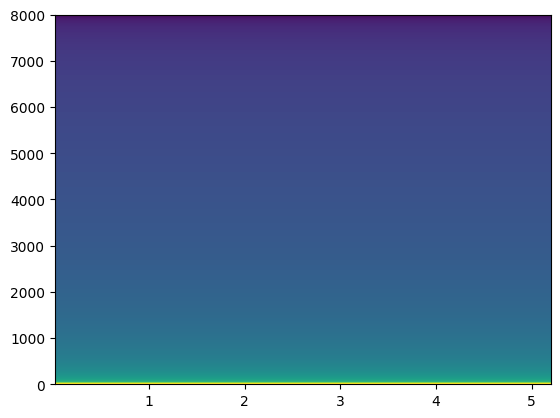

In [154]:
bckgrnd_sig = np.ones(3*len(downsampled_data))

plt.specgram(bckgrnd_sig, NFFT=n, Fs=new_fs, noverlap=int(n/2), scale = "dB")
plt.show()